# User-Based Memory Model

This notebook looks at building an item-item collaborative filtering model using the movielens dataset. If you wish to understand the theory behind item-item models please refer to the `01_intro` notebook.

In [2]:
from typing import (
    Tuple,
    Union
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

Read in the data into the dataframe:

In [3]:
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', header=None)
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_titles = pd.read_csv('./ml-100k/u.item', sep='|', header=None, encoding="ISO-8859-1")
movie_titles.columns = """movie_id | movie_title | release_date | video_release_date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Childrens | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western""".replace('\n', '').replace(' ', '').split('|')

In [4]:
ratings = pd.merge(ratings, movie_titles[['movie_id', 'movie_title']], left_on='movie_id', right_on='movie_id')
ratings

,user_id,movie_id,rating,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


Create a pivot table to with users as rows and movies as columns

In [5]:
user_item = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')
user_item

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Subtract the mean rating for each user for the movies they rated and fill in the empties with zero. This results in the mean for each user being zero allowing us to fill in the `NA`s with zero.

In [6]:
user_item_cosine_adjusted = user_item.sub(user_item.mean(axis=1), axis=0)
user_item_cosine_adjusted = user_item_cosine_adjusted.fillna(0)

In [7]:
user_item_cosine_adjusted

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,-0.610294,0.389706,-0.610294,-0.610294,1.389706,0.389706,-2.610294,1.389706,-0.610294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.290323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.709677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.125714,0.125714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.734694,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.000000,0.000000,0.000000,-1.457944,0.000000,0.000000,0.542056,1.542056,-0.457944,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.954545,0.000000,0.000000,0.000000,0.000000,0.000000,-0.045455,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create an user-user similarity matrix scoring via cosine similarity

In [8]:
user_user_sim = pd.DataFrame(cosine_similarity(user_item_cosine_adjusted, user_item_cosine_adjusted), columns=user_item_cosine_adjusted.index, index=user_item_cosine_adjusted.index)
user_user_sim

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.043411,0.011051,0.059303,0.134514,0.103373,0.110556,0.180891,0.012253,-0.000621,...,0.025835,-0.047952,0.087224,0.007718,0.074378,0.078714,0.067433,0.028790,-0.031270,0.032123
2,0.043411,1.000000,0.013658,-0.017016,0.035770,0.094503,0.089408,0.055640,0.027294,0.097846,...,0.012853,-0.028798,0.056659,0.197835,0.090009,0.032505,0.015053,-0.017344,0.012068,0.039173
3,0.011051,0.013658,1.000000,-0.059638,0.016037,-0.017158,0.016141,0.041177,-0.010093,0.023856,...,0.001615,0.000658,-0.006888,0.036157,-0.018513,-0.006240,-0.023907,0.034414,-0.009187,0.001489
4,0.059303,-0.017016,-0.059638,1.000000,0.007373,-0.053929,-0.025604,0.136046,0.016082,-0.013588,...,0.011895,0.002174,-0.028000,-0.025021,0.022882,-0.005960,0.279818,0.258594,0.064504,-0.019222
5,0.134514,0.035770,0.016037,0.007373,1.000000,0.038484,0.067874,0.140106,0.010195,0.014335,...,0.070014,-0.070821,0.024278,0.038672,0.093567,0.051782,0.029540,0.036234,0.043318,0.099324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.078714,0.032505,-0.006240,-0.005960,0.051782,-0.047520,0.013584,0.025026,0.018475,0.014387,...,0.032608,-0.004944,0.064036,-0.035230,0.019929,1.000000,0.016835,-0.030376,-0.023190,0.004451
940,0.067433,0.015053,-0.023907,0.279818,0.029540,-0.012071,0.005844,0.078222,0.004491,0.044572,...,-0.029460,0.054646,-0.059929,-0.032935,0.022646,0.016835,1.000000,0.102008,-0.011483,0.065414
941,0.028790,-0.017344,0.034414,0.258594,0.036234,0.001559,0.001943,0.057949,0.040748,0.026179,...,-0.025764,-0.031663,0.057585,0.094183,-0.094838,-0.030376,0.102008,1.000000,-0.019055,0.000666


In [9]:
user_user_sim_matrix = user_user_sim.to_numpy()

The functions below:
- **get_similar_users**: Obtains `k` similar users to the `user_id`. Returns the item User IDs and the similarity score
- **predict_rating**: Predicts the rating for a `item_id` for a given `user_id`. The rating is calculated via the weighted sum.

In [11]:
def get_similar_users(user_id: int, k: int=20) -> Tuple[np.array, np.array]:
    """
    Obtains the most similar users to a given user ID
    
    :type user_id: int
    :param user_id: ID of the movie
    :type k: int
    :param k: number of nearest neighbors
    :rtype: Tuple[np.array, np.array]
    :return: Indices of k most similar users along with the similarity score
    """
    user_row = user_user_sim_matrix[user_id - 1,]
    sim_indices = np.argsort(user_row)[::-1][1:k+1]
    sim_scores = user_row[sim_indices]
    return sim_indices + 1, sim_scores

def predict_rating(user_id: int, item_id: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_users, sim_scores = get_similar_users(user_id)
    sim_user_rated = user_item[item_id][sim_users] # Obtain ratings of item by similar users
    sim_user_rated_filtered = np.argwhere(~np.isnan(sim_user_rated.values)).flatten() # Get indicies of ratings where they are not nan
    if np.any(sim_user_rated_filtered):
        return np.dot(sim_scores[sim_user_rated_filtered], sim_user_rated.values[sim_user_rated_filtered]) / np.sum(sim_scores[sim_user_rated_filtered])
    else:
        return None

In [12]:
predict_rating(1, 1) # Actual is 5

3.775420937724738

Run the predictions on the data the similarity was calculated from.

In [13]:
true_ratings = []
pred_ratings = []
for row in ratings.itertuples():
    try:
        predicted_rating = predict_rating(row.user_id, row.movie_id)
        if predicted_rating:
            pred_ratings.append(predicted_rating)
            true_ratings.append(row.rating)
    except KeyError:
        continue
print(mean_absolute_error(true_ratings, pred_ratings))

0.7179254016188971


## Train and Test Set

The dataset come with a set of training and test sets. Let's evaluate the user-item model

The first thing to do is to read in the training data

In [14]:
training = pd.read_csv('./ml-100k/u1.base', sep='\t', header=None)
training.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

The next steps are the same as above:

- Create user-item table
- Cosine adjust the ratings
- Create user-user similarity matrix

In [15]:
user_item = training.pivot_table(index='user_id', columns='movie_id', values='rating')
user_item_cosine_adjusted = user_item.sub(user_item.mean(axis=1), axis=0)
user_item_cosine_adjusted = user_item_cosine_adjusted.fillna(0)
user_user_sim = pd.DataFrame(cosine_similarity(user_item_cosine_adjusted, user_item_cosine_adjusted), columns=user_item_cosine_adjusted.index, index=user_item_cosine_adjusted.index)
user_user_sim_matrix = user_user_sim.to_numpy()

Here, there is an additional step. Since we can't be sure that all the items in the training data are present in the test data we need to create a mapping of the item ID to row index in the item-item matrix

In [16]:
user_id_to_index = {u_id: i for i, u_id in enumerate(user_user_sim.index)}

The only difference here is that the `user_id` is looked up to find its corresponding row in the matrix:

In [17]:
def get_similar_users_test(user_index: int, k: int=20) -> Tuple[np.array, np.array]:
    """
    Obtains the most similar users to a given user ID
    
    :type item_index: int
    :param item_index: Index of the item in the similarity matrix
    :type k: int
    :param k: number of nearest neighbors
    :rtype: Tuple[np.array, np.array]
    :return: Indices of k most similar items along with the similarity score
    """
    user_row = user_user_sim_matrix[user_index,]
    sim_indices = np.argsort(user_row)[::-1][1:k+1]
    sim_scores = user_row[sim_indices]
    return sim_indices + 1, sim_scores

def predict_rating_test(user_id: int, item_id: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_users, sim_scores = get_similar_users(user_id_to_index[user_id])
    sim_user_rated = user_item[item_id][sim_users] # Obtain ratings of item by similar users
    sim_user_rated_filtered = np.argwhere(~np.isnan(sim_user_rated.values)).flatten() # Get indicies of ratings where they are not nan
    if np.any(sim_user_rated_filtered):
        return np.dot(sim_scores[sim_user_rated_filtered], sim_user_rated.values[sim_user_rated_filtered]) / np.sum(sim_scores[sim_user_rated_filtered])
    else:
        return None

In [18]:
predict_rating_test(1,1)

4.0140242393921115

Run the model against the test data and calculate the error:

In [19]:
test_data = pd.read_csv('./ml-100k/u1.test', sep='\t', header=None)
test_data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

In [20]:
true_ratings = []
pred_ratings = []
for row in test_data.itertuples():
    try:
        predicted_rating = predict_rating_test(row.user_id, row.movie_id)
        if predicted_rating:
            pred_ratings.append(predicted_rating)
            true_ratings.append(row.rating)
    except KeyError:
        continue
print(mean_absolute_error(true_ratings, pred_ratings))

0.9342260456546668


## What is the Best K?

Above, I've arbitrarily chosen a K of 20. Is this the best value? Let's try a range of K:

In [21]:
# Same function as above, but now we can pass a K parameter
def predict_rating_test(user_id: int, item_id: int, k: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_users, sim_scores = get_similar_users(user_id_to_index[user_id], k=k)
    sim_user_rated = user_item[item_id][sim_users] # Obtain ratings of item by similar users
    sim_user_rated_filtered = np.argwhere(~np.isnan(sim_user_rated.values)).flatten() # Get indicies of ratings where they are not nan
    if np.any(sim_user_rated_filtered):
        return np.dot(sim_scores[sim_user_rated_filtered], sim_user_rated.values[sim_user_rated_filtered]) / np.sum(sim_scores[sim_user_rated_filtered])
    else:
        return None

In [22]:
scores = []
for k in range(5, 30 + 1):
    true_ratings = []
    pred_ratings = []
    for row in test_data.itertuples():
        try:
            predicted_rating = predict_rating_test(row.user_id, row.movie_id, k)
            if predicted_rating:
                pred_ratings.append(predicted_rating)
                true_ratings.append(row.rating)
        except KeyError:
            continue
    scores.append(mean_absolute_error(true_ratings, pred_ratings))

Text(0, 0.5, 'MAE')

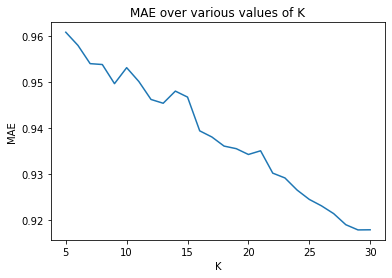

In [23]:
sns.lineplot(range(5, 30 + 1), scores)
plt.title('MAE over various values of K')
plt.xlabel('K')
plt.ylabel('MAE')